<a href="https://colab.research.google.com/github/themathedges/3YP-Standalone-Kennington/blob/main/Ravi/Sandford_Generation_models/Model_6_Multivariate_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 6: Multivariate Regression (Daily)

**Author:** Ravi Kohli

**Date:** January 6th, 2021

**College:** Christ Church

**Goal:**
- To make a very simple multivariate linear regression monthly model to forecast the future generation profile of Sandford Hydro

In [ ]:
# Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import the modules
import numpy as np
import pandas as pd
from pandas import Timestamp
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import pearsonr
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

## Collecting the Data

### Defining the Mask

In [ ]:
# extract the rows that we want by using a mask
# format of mask: YYYY-MM-DD
model_6_current_mask_start = pd.to_datetime('2018-12-01')
model_6_current_mask_end = pd.to_datetime('2019-10-22')

### Daily Current Generation

In [ ]:
# unpickle the processed daily generation dataframe
path = '/content/drive/My Drive/3YP/data/'
filename = 'daily_sandford_generation_data'
infile = open(path+filename, 'rb')
sandford_daily_df = pickle.load(infile)
infile.close()

In [ ]:
sandford_daily_df

,Reading Date,Incremental Reading,Meter Reading
0,2019-10-22,1284.10,1763145.53
1,2019-10-21,1175.01,1761861.43
2,2019-10-20,1175.01,NaN
3,2019-10-19,1175.01,NaN
4,2019-10-18,2265.09,1758336.41
...,...,...,...
364,2018-10-22,0.00,548149.91
365,2018-10-21,0.00,548149.91
366,2018-10-20,0.00,548149.91
367,2018-10-19,0.00,548149.91


In [ ]:
model_6_gen_current_mask = (sandford_daily_df['Reading Date'] >= model_6_current_mask_start) & (sandford_daily_df['Reading Date'] <= model_6_current_mask_end)

# extract the rows from the dataframe by using the mask
sandford_gen_df = sandford_daily_df.loc[model_6_gen_current_mask]

In [ ]:
sandford_gen_df

,Reading Date,Incremental Reading,Meter Reading
0,2019-10-22,1284.100,1763145.53
1,2019-10-21,1175.010,1761861.43
2,2019-10-20,1175.010,NaN
3,2019-10-19,1175.010,NaN
4,2019-10-18,2265.090,1758336.41
...,...,...,...
320,2018-12-05,12.493,551201.08
321,2018-12-04,0.000,551188.58
322,2018-12-03,0.000,551188.58
323,2018-12-02,2.765,551188.58


### Daily Precipitation

In [ ]:
# unpickle the current precipitation daily dataframe
path = '/content/drive/My Drive/3YP/data/'
filename = 'radcliffe_daily_precipitation_data_processed'
infile = open(path+filename, 'rb')
precipitation_daily_df = pickle.load(infile)
infile.close()

In [ ]:
model_6_precip_current_mask = (precipitation_daily_df['Date'] >= model_6_current_mask_start) & (precipitation_daily_df['Date'] <= model_6_current_mask_end)

# extract the rows from the dataframe by using the mask
precipitation_current_df = precipitation_daily_df.loc[model_6_precip_current_mask]

### Daily Temperature data

In [ ]:
# unpickle the temperature daily dataframe
path = '/content/drive/My Drive/3YP/data/'
filename = 'radcliffe_daily_temperature_data_processed'
infile = open(path+filename, 'rb')
temperature_daily_df = pickle.load(infile)
infile.close()

In [ ]:
model_6_temp_current_mask = (temperature_daily_df['Date'] >= model_6_current_mask_start) & (temperature_daily_df['Date'] <= model_6_current_mask_end)

# extract the rows from the dataframe by using the mask
temp_current_df = temperature_daily_df.loc[model_6_temp_current_mask]

### Daily Snowfall data: current

In [ ]:
# unpickle the snowfall daily dataframe
path = '/content/drive/My Drive/3YP/data/met_office/'
filename = 'snowfall_2242_met_daily'
infile = open(path+filename, 'rb')
snowfall_daily_df = pickle.load(infile)
infile.close()

In [ ]:
snowfall_daily_df

,Date,Snowfall
0,1980-12-01,0.047270
1,1980-12-02,0.050254
2,1980-12-03,1.431502
3,1980-12-04,0.241387
4,1980-12-05,0.460901
...,...,...
25225,2050-12-26,0.000000
25226,2050-12-27,0.000000
25227,2050-12-28,0.000000
25228,2050-12-29,0.000000


In [ ]:
model_6_snow_current_mask = (snowfall_daily_df['Date'] >= model_6_current_mask_start) & (snowfall_daily_df['Date'] <= model_6_current_mask_end)

# extract the rows from the dataframe by using the mask
snowfall_current = snowfall_daily_df.loc[model_6_snow_current_mask]

In [ ]:
snowfall_current.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 13680 to 14001
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      320 non-null    datetime64[ns]
 1   Snowfall  320 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.5 KB


### Future Precipitation data

In [ ]:
# unpickle the future temperature dataframe
path = '/content/drive/My Drive/3YP/data/met_office/'
filename = 'precip_2242_met_daily' 
infile = open(path+filename, 'rb')
precipitation_future_df = pickle.load(infile)
infile.close()

In [ ]:
# extract the rows that we want by using a mask
# format of mask: YYYY-MM-DD
model_6_future_mask_start = pd.to_datetime('2050-01-01')
model_6_future_mask_end = pd.to_datetime('2050-12-31')

In [ ]:
model_6_precip_future_mask = (precipitation_future_df['Date'] >= model_6_future_mask_start) & (precipitation_future_df['Date'] <= model_6_future_mask_end)

# extract the rows from the dataframe by using the mask
precipitation_future = precipitation_future_df.loc[model_6_precip_future_mask]

In [ ]:
precipitation_future

,Date,Precipitation Rate
24870,2050-01-01,10.622042
24871,2050-01-02,26.987028
24872,2050-01-03,11.353615
24873,2050-01-04,0.251311
24874,2050-01-05,1.852849
...,...,...
25225,2050-12-26,0.000615
25226,2050-12-27,5.991373
25227,2050-12-28,4.328137
25228,2050-12-29,0.100387


### Future Temperature Data

In [ ]:
# unpickle the future temperature dataframe
path = '/content/drive/My Drive/3YP/data/met_office/'
filename = 'temp_2242_met_daily'
infile = open(path+filename, 'rb')
temperature_future_df = pickle.load(infile)
infile.close()

In [ ]:
temperature_future_df

,Date,Temperature
0,1980-12-01,-0.965012
1,1980-12-02,-0.719904
2,1980-12-03,0.271304
3,1980-12-04,-5.000383
4,1980-12-05,-3.902606
...,...,...
25225,2050-12-26,8.359898
25226,2050-12-27,8.109031
25227,2050-12-28,7.250457
25228,2050-12-29,7.026456


In [ ]:
model_6_temp_future_mask = (temperature_future_df['Date'] >= model_6_future_mask_start) & (temperature_future_df['Date'] <= model_6_future_mask_end)

# extract the rows from the dataframe by using the mask
temperature_future = temperature_future_df.loc[model_6_temp_future_mask]

### Future Snowfall data

In [ ]:
model_6_snow_future_mask = (snowfall_daily_df['Date'] >= model_6_future_mask_start) & (snowfall_daily_df['Date'] <= model_6_future_mask_end)

# extract the rows from the dataframe by using the mask
snow_future = snowfall_daily_df.loc[model_6_snow_future_mask]

## Multivariate Regression Analysis

In [ ]:
model_6 = LinearRegression()

In [ ]:
# note the indexing as we need to exclude november and start the data as december
model_6_train_df = pd.DataFrame([precipitation_current_df['Date']]).T
model_6_train_df['Mean_temp'] = temp_current_df['Daily Tmean °C']
model_6_train_df['Total_precip'] = precipitation_current_df['Rainfall mm 1 dpl no traces']

In [ ]:
# define a set of dates that need to be removed from the rest of the training data sets
dates_to_remove = set(model_6_train_df['Date']) - (set(snowfall_current['Date']))
dates_to_remove

{Timestamp('2018-12-31 00:00:00'),
 Timestamp('2019-01-31 00:00:00'),
 Timestamp('2019-03-31 00:00:00'),
 Timestamp('2019-05-31 00:00:00'),
 Timestamp('2019-07-31 00:00:00'),
 Timestamp('2019-08-31 00:00:00')}

In [ ]:
# remove the row with the extra date from the snowfall data
snowfall_current_removed = snowfall_current[snowfall_current['Date'] != '2019-06-01 00:00:00']

# remove the row with the extra date from the training data
model_6_train = model_6_train_df[model_6_train_df['Date'] != '2019-06-01 00:00:00']
model_6_train['Total_daily_generation'] = sandford_gen_df['Incremental Reading'].values[::-1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# now we want to exclude the row whose date isn't in the generation data
for i in dates_to_remove:
  model_6_train = model_6_train[model_6_train['Date'] != i]

In [ ]:
# reset the indices to try and align them
snowfall_current_removed.reset_index(drop = True)
model_6_train.reset_index(drop = True)

,Date,Mean_temp,Total_precip,Total_daily_generation
0,2018-12-01,9.9,3.1,1272.220
1,2018-12-02,11.6,1.0,2.765
2,2018-12-03,11.8,2.7,0.000
3,2018-12-04,5.3,8.5,0.000
4,2018-12-05,7.6,0.0,12.493
...,...,...,...,...
314,2019-10-18,11.3,0.2,2265.090
315,2019-10-19,11.1,0.0,1175.010
316,2019-10-20,8.1,0.0,1175.010
317,2019-10-21,10.8,0.0,1175.010


In [ ]:
# the .to_numpy() argument is used to bypass the problems due to index misalignment
model_6_train['Snowfall'] = snowfall_current_removed['Snowfall'].to_numpy()

In [ ]:
model_6_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319 entries, 74479 to 74804
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    319 non-null    datetime64[ns]
 1   Mean_temp               319 non-null    float64       
 2   Total_precip            319 non-null    float64       
 3   Total_daily_generation  319 non-null    float64       
 4   Snowfall                319 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 15.0 KB


In [ ]:
# get the training features and target vector
x_train = model_6_train[['Mean_temp', 'Total_precip', 'Snowfall']]
y_train = model_6_train['Total_daily_generation']

In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319 entries, 74479 to 74804
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Mean_temp     319 non-null    float64
 1   Total_precip  319 non-null    float64
 2   Snowfall      319 non-null    float64
dtypes: float64(3)
memory usage: 10.0 KB


In [ ]:
# form the testing data dataframe
model_6_test_df = temperature_future[['Date', 'Temperature']]
model_6_test_df['Future_precip'] = precipitation_future['Precipitation Rate']
model_6_test_df['Future_snowfall'] = snow_future['Snowfall'].fillna(0)

In [ ]:
model_6_test_df = model_6_test_df.reset_index(drop = True)
#model_6_test_df.index[np.isinf(model_6_test_df['Snowfall']).any(1)]
# model_6_test_df['Temperature'].isnull().values.any()

In [ ]:
model_6_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             358 non-null    datetime64[ns]
 1   Temperature      358 non-null    float64       
 2   Future_precip    358 non-null    float64       
 3   Future_snowfall  358 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 11.3 KB


In [ ]:
model_6.fit(x_train, y_train)
print(model_6.intercept_, model_6.coef_)

8529.777265327111 [-398.64561969  -30.88599514 -156.09144972]


In [ ]:
# make predictions on the future
y_pred = model_6.predict(model_6_test_df[['Temperature', 'Future_precip', 'Future_snowfall']])

In [ ]:
y_pred_corrected = [max(i, 0) for i in y_pred]
model_6_test_df['Predicted generation'] = y_pred_corrected
model_6_test_df['Generation rolling average'] = model_6_test_df['Predicted generation'].rolling(10).mean()
print(sum(y_pred_corrected))

1201330.3950030042


In [ ]:
(1201330.3950030042 - 1211960)/1211960 * 100

-0.877059061107278

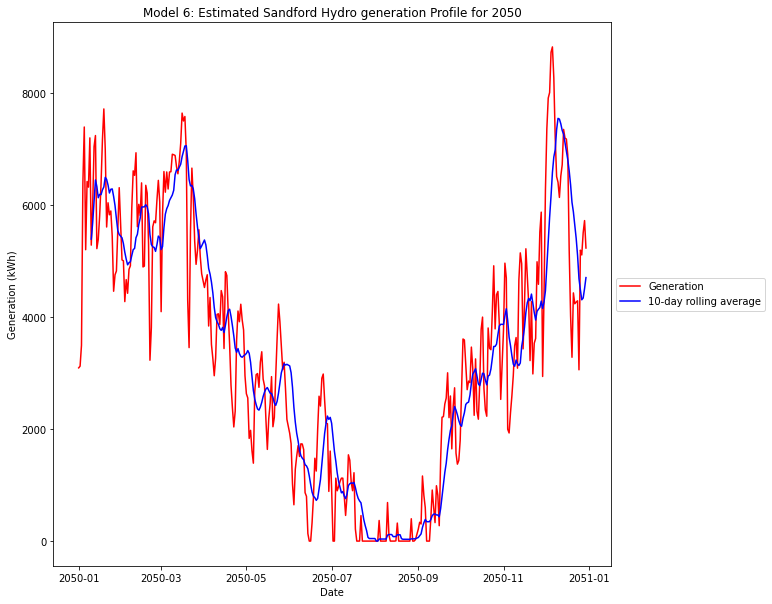

In [ ]:
# Let us plot the generation profile
gen_fig, gen_ax = plt.subplots(figsize = (10, 10))
gen_ax.plot(temperature_future['Date'], model_6_test_df['Predicted generation'], 'r', label = 'Generation')  
gen_ax.plot(temperature_future['Date'], model_6_test_df['Generation rolling average'], 'b', label = '10-day rolling average')  
gen_ax.set(title = 'Model 6: Estimated Sandford Hydro generation Profile for 2050', xlabel= 'Date', ylabel='Generation (kWh)')
gen_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

Now we will run the same Linear Regression, but we will standardise the data now using the sklearn function `StandardScaler()`

In [ ]:
model_6_scaled = LinearRegression()
model_6_scaler = StandardScaler()

In [ ]:
# standardise the training data
x_train_scaled = model_6_scaler.fit_transform(x_train) 
y_train_scaled = model_6_scaler.fit_transform(y_train.values.reshape((-1, 1)))

In [ ]:
# process the testing data
model_6_scaler.fit(x_train)
model_6_test = model_6_scaler.transform(model_6_test_df[['Temperature', 'Future_precip', 'Future_snowfall']])

In [ ]:
# conduct the regression
model_6_scaled.fit(x_train_scaled, y_train_scaled)
print(model_6_scaled.intercept_, model_6_scaled.coef_)

[3.99466236e-16] [[-0.68203015 -0.03757658 -0.01701103]]


In [ ]:
# make predictions on the future
y_pred_scaled = model_6_scaled.predict(model_6_test)

In [ ]:
y_pred_corrected_scaled = [max(i, 0) for i in y_pred_scaled]
print(sum(y_pred_corrected_scaled))

[91.05901617]
